<a href="https://colab.research.google.com/github/MaayanHagbi/CAS_ADS_Final_Project/blob/main/Fraud_Detection_ML_(CAS_ADS).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Mount Drive & Authenticate Google Big Query Access

In [1]:
from google.colab import drive
from google.colab import auth
drive.mount('/content/drive')
auth.authenticate_user()
print('Authenticated')

Mounted at /content/drive
Authenticated


#Load Packages

In [2]:
#Google Big Query related packages
from google.cloud import bigquery
import pandas as pd
import numpy as np
import seaborn as sns
import os
import matplotlib.pyplot as plt
!pip install geoip2
import geoip2.database
import time
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import RobustScaler

#Clone Repository
!git clone https://github.com/MaayanHagbi/CAS_ADS_Final_Project

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.8/87.8 kB 3.7 MB/s eta 0:00:00
Cloning into 'CAS_ADS_Final_Project'...
remote: Enumerating objects: 74, done.
remote: Counting objects: 100% (74/74), done.
remote: Compressing objects: 100% (72/72), done.
remote: Total 74 (delta 22), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (74/74), 669.62 KiB | 7.44 MiB/s, done.
Resolving deltas: 100% (22/22), done.


# Connect to Big Query and Get Data

In [3]:
project_id = 'total-biplane-387513'
bigquery_client = bigquery.Client(project = project_id)

Query = """
    Select distinct * from (
    Select * from `Data_Sceince_Project_Dataset.CAS_ADS_Dataset` where
    Clientinfo_id in (Select distinct Clientinfo_id from `Data_Sceince_Project_Dataset.CAS_ADS_Dataset`
    where Chargebackreason_code in ('10','10.4','13','4837','4853'))
    union all
    Select * from `Data_Sceince_Project_Dataset.CAS_ADS_Dataset` where Clientinfo_id in (
    Select distinct Clientinfo_id from `Data_Sceince_Project_Dataset.CAS_ADS_Dataset`
    where Clientinfo_id not in (Select Clientinfo_id from `Data_Sceince_Project_Dataset.CAS_ADS_Dataset`
    where Chargebackreason_id is null and Clientinfo_id not in ((Select distinct Clientinfo_id from `Data_Sceince_Project_Dataset.CAS_ADS_Dataset`
    where Chargebackreason_code in ('10','10.4','13','4837','4853')))) limit 6000)
    ); """
Query_Results = bigquery_client.query(Query)
Data_Adf = Query_Results.to_dataframe()
Data_Adf = Data_Adf.drop_duplicates(subset=['id'])
Data_Adf

,id,transaction_sn,cluster_sn,amount,amount_gbp,ip,processor_timestamp,arn,recurring_sn,dispute_age,...,MCCs_created_at,Accountmanager_id,Accountmanager_name,Accountmanager_updated_at,Accountmanager_created_at,Chargebackreason_id,Chargebackreason_code,Chargebackreason_description,Chargebackreason_updated_at,Chargebackreason_created_at
0,7555368,ajE0i9q1,f5gBjzpG,219.000000000,219.000000000,141.98.103.23,2023-03-01 08:30:42+00:00,74595343061000008971539,None,<NA>,...,NaT,23,Hai Shmool,2020-04-18 23:08:37+00:00,NaT,4,10.4,Other Fraud: Card-absent Environment/Condition,2023-06-22 12:56:52+00:00,NaT
1,7692121,0yvelJQw,sOvSR6He,99.000000000,78.320000000,185.203.122.196,2023-03-14 10:12:00+00:00,74595343074000008677719,None,<NA>,...,NaT,23,Hai Shmool,2020-04-18 23:08:37+00:00,NaT,4,10.4,Other Fraud: Card-absent Environment/Condition,2023-06-22 12:56:52+00:00,NaT
2,9305837,z730iHB8,PLaXF2GU,4200.000000000,3323.050000000,89.191.205.77,2023-08-23 17:21:28+00:00,85301163235333770826837,None,<NA>,...,NaT,23,Hai Shmool,2020-04-18 23:08:37+00:00,NaT,29,4853,Cardholder Dispute,2023-06-22 12:56:52+00:00,NaT
3,2370608,7uwLPL9D,6UKcdsqF,47.000000000,37.640000000,74.102.20.221,2021-02-27 09:10:26+00:00,None,None,<NA>,...,NaT,<NA>,None,NaT,NaT,48,13,Customer Disputes,2023-06-22 12:56:52+00:00,NaT
4,2356355,4je5o8kB,z5U7vRWJ,47.000000000,37.640000000,2600:387:0:80d::74,2021-02-24 15:09:52+00:00,None,None,<NA>,...,NaT,<NA>,None,NaT,NaT,34,4837,No Cardholder Authorization,2023-06-22 12:56:52+00:00,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27067,7081825,SyUNAk3N,e8AofZ3X,72.000000000,72.000000000,77.77.215.130,2023-01-09 09:22:04+00:00,74836953010358940270676,None,<NA>,...,NaT,427,Gareth De Klerk,2024-03-27 13:21:07+00:00,NaT,<NA>,None,None,NaT,NaT
27068,9364872,UqL5VyEU,pLopGCsH,72.000000000,72.000000000,154.66.156.192,2023-09-01 10:17:28+00:00,74836953245358962368801,None,<NA>,...,NaT,427,Gareth De Klerk,2024-03-27 13:21:07+00:00,NaT,<NA>,None,None,NaT,NaT
27069,10827815,hucnnMbf,hbbe4si3,400.000000000,316.510000000,124.217.189.136,2024-02-07 05:45:32+00:00,74836954039358853000867,None,<NA>,...,NaT,427,Gareth De Klerk,2024-03-27 13:21:07+00:00,NaT,<NA>,None,None,NaT,NaT
27070,7207061,PNxB8L9A,ua8Ecz5p,72.000000000,72.000000000,77.238.211.60,2023-01-22 19:06:31+00:00,74836953023358812174324,None,<NA>,...,NaT,427,Gareth De Klerk,2024-03-27 13:21:07+00:00,NaT,<NA>,None,None,NaT,NaT


#Check whether there are any duplicate ID's

In [4]:
duplicate_rows = Data_Adf[Data_Adf.duplicated(subset=['id'])]
duplicate_rows

,id,transaction_sn,cluster_sn,amount,amount_gbp,ip,processor_timestamp,arn,recurring_sn,dispute_age,...,MCCs_created_at,Accountmanager_id,Accountmanager_name,Accountmanager_updated_at,Accountmanager_created_at,Chargebackreason_id,Chargebackreason_code,Chargebackreason_description,Chargebackreason_updated_at,Chargebackreason_created_at


#Conversion and Creation of Variables

In [5]:
def convert_float(columns):
  for col in columns:
    Data_Adf[col] = pd.to_numeric(Data_Adf[col],errors='coerce')

def convert_string(columns):
  for col in columns:
    Data_Adf[col] = Data_Adf[col].astype(str)

columns_to_string = ['id']
columns_to_float = ['amount_gbp']

convert_float(columns_to_float)
convert_string(columns_to_string)

#Add Is_fraud Column
Data_Adf['Is_fraud'] = Data_Adf['Chargebackreason_id'].notnull()

#Data Analysis

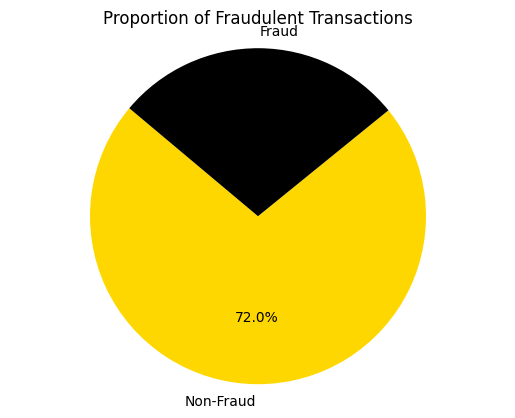

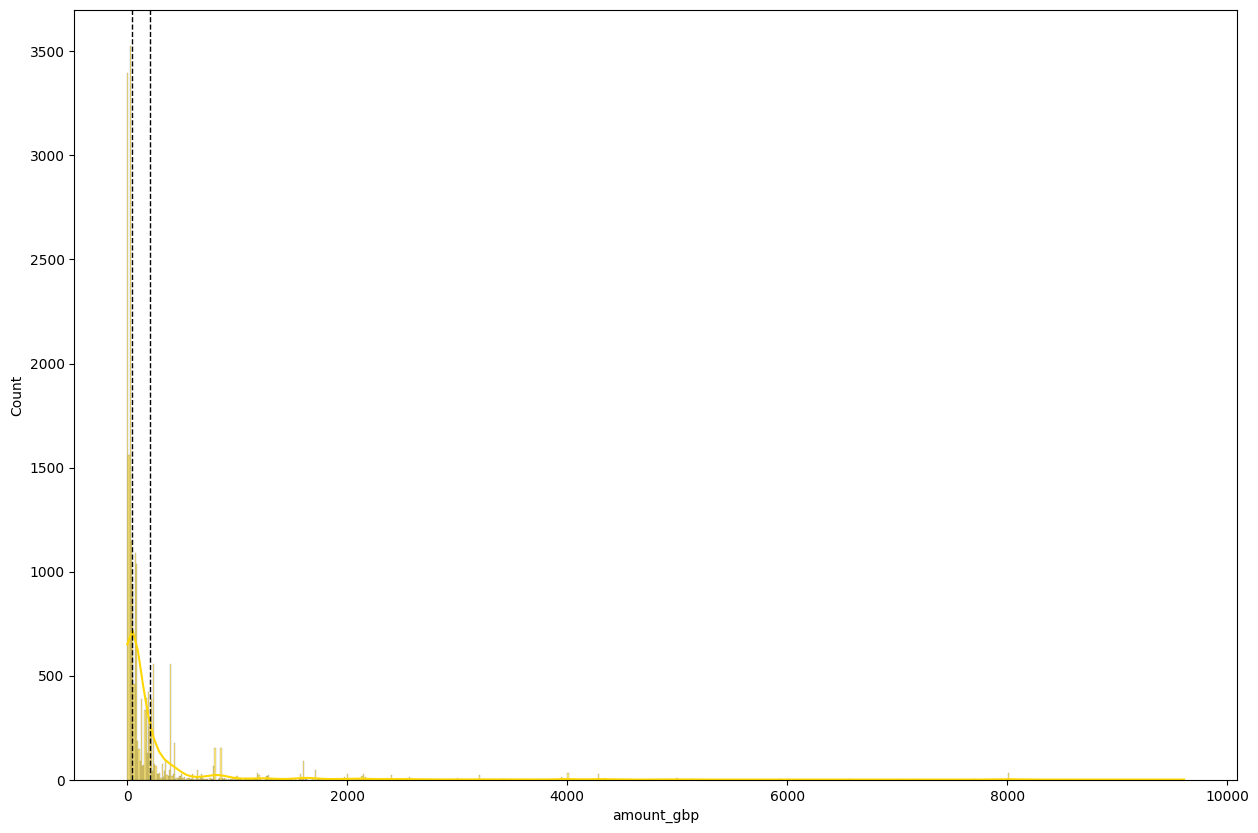

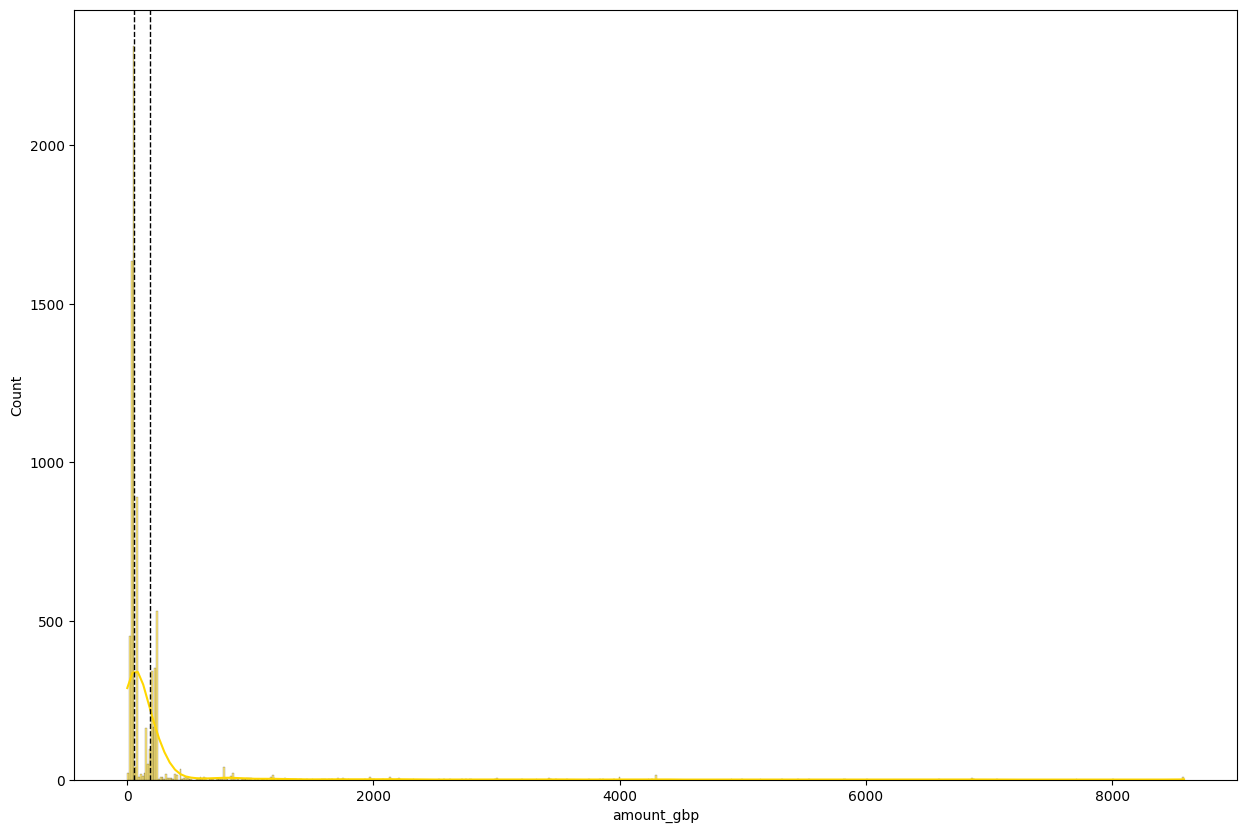

In [6]:
#Look into share of fradulent trx vs non-fraudulent
Data_Adf["Is_fraud"].value_counts().plot.pie(labels=['Non-Fraud','Fraud'],colors=['gold','black'], autopct='%1.1f%%',startangle=140,textprops={'color':"black"})
plt.title('Proportion of Fraudulent Transactions')
plt.ylabel('')
plt.axis('equal')
plt.show()

#Check Amount distribution of Fraudulent Vs non Fraudulent Trx
fraudulent_df = Data_Adf[Data_Adf["Is_fraud"]==True]
non_fraudulent_df = Data_Adf[Data_Adf["Is_fraud"]==False]

#Trx_amount_gbp
plt.figure(figsize=(15,10))
sns.histplot(non_fraudulent_df["amount_gbp"], kde=True, color='gold', edgecolor='black')
mean_value = np.mean(non_fraudulent_df["amount_gbp"])
median_value = np.median(non_fraudulent_df["amount_gbp"])
plt.axvline(mean_value, color='black', linestyle='dashed', linewidth=1)
plt.axvline(median_value, color='black', linestyle='dashed', linewidth=1)
plt.show()


plt.figure(figsize=(15,10))
sns.histplot(fraudulent_df["amount_gbp"], kde=True, color='gold', edgecolor='black')
mean_value = np.mean(fraudulent_df["amount_gbp"])
median_value = np.median(fraudulent_df["amount_gbp"])
plt.axvline(mean_value, color='black', linestyle='dashed', linewidth=1)
plt.axvline(median_value, color='black', linestyle='dashed', linewidth=1)
plt.show()

#Generate Customer Profiles (Cust_Profiles)

In [8]:
#Calcualte Customer Profile Statistics
cust_profiles = Data_Adf.groupby('Clientinfo_id')['amount_gbp'].agg(['mean','median']).reset_index()
cust_profiles.columns = ['client_id','cust_profiles_mean_gbp_amount','cust_profiles_median_gbp_amount']
cust_profiles_std = Data_Adf.groupby('Clientinfo_id')['amount_gbp'].std(ddof=0).reset_index()
cust_profiles_std.columns = ['client_id','cust_profiles_std_gbp_amount']


#Calcualte Average Number of Trx
Data_Adf['timestamp'] = pd.to_datetime(Data_Adf['timestamp'],errors='coerce')
trx_per_day_per_customer = Data_Adf.groupby(['Clientinfo_id', Data_Adf['timestamp'].dt.date]).size().reset_index(name='num_transactions')
mean_nb_trx_per_day = trx_per_day_per_customer.groupby('Clientinfo_id')['num_transactions'].mean().reset_index()
mean_nb_trx_per_day.columns = ['client_id','cust_profiles_mean_nb_trx_per_day']

#Merge Datasets to one
Cust_Profiles = pd.merge(cust_profiles,cust_profiles_std,on='client_id')
Cust_Profiles = pd.merge(cust_profiles,mean_nb_trx_per_day,on='client_id')

#Cust_Profiles_Data
Cust_Profiles

,client_id,cust_profiles_mean_gbp_amount,cust_profiles_median_gbp_amount,cust_profiles_mean_nb_trx_per_day
0,1058555,53.65,53.65,1.0
1,1058557,53.65,53.65,1.0
2,1058558,157.75,157.75,1.0
3,1058568,157.75,157.75,1.0
4,1058569,157.75,157.75,1.0
...,...,...,...,...
12668,4640151,60.60,60.60,1.0
12669,4640332,58.07,58.07,1.0
12670,4640420,37.63,37.63,1.0
12671,4640970,380.31,380.31,1.0


# Get Customer Country from IP Address / Card Info (Cust_Country_Profile)

In [9]:
def get_country(ip):
    mmdb_file_path = '/content/drive/MyDrive/CAS_Final_Project/GeoLite2-City.mmdb'

    if pd.notna(ip) and ip != 'nan':
        try:
            with geoip2.database.Reader(mmdb_file_path) as reader:
                response = reader.city(ip)

                country_name = response.country.name
                country_iso_code = response.country.iso_code
                return country_name, country_iso_code
        except Exception as e:
            return 0, 0
    else:
        return 0, 0

df_Country_lan_lat = pd.read_csv("/content/drive/MyDrive/CAS_Final_Project/Country_lan_lat.csv",sep=';')

In [10]:
#Get Customer Device IP Coordinates (Country)
Cust_Country_Profile_Ip = Data_Adf[['id','Clientinfo_id','Deviceinfo_ip']].copy()
Cust_Country_Profile_Ip['Deviceinfo_ip'] = Cust_Country_Profile_Ip['Deviceinfo_ip'].astype(str)
Cust_Country_Profile_Ip[['country_name','country']] = Cust_Country_Profile_Ip['Deviceinfo_ip'].apply(lambda x:  pd.Series(get_country(x)))

merge_df = pd.merge(Cust_Country_Profile_Ip,df_Country_lan_lat,on='country',how='left')

columns_to_keep = ['id','Clientinfo_id','latitude','longitude']
Cust_Country_Profile_Ip = merge_df[columns_to_keep]

old_colums_names = ['id','Clientinfo_id','latitude','longitude']
new_columns_names = ['id','client_id','latitude_ip','longitude_ip']
new_columns_dic =  {k: v for k, v in zip(old_colums_names,new_columns_names)}
Cust_Country_Profile_Ip = Cust_Country_Profile_Ip.rename(columns=new_columns_dic)
Cust_Country_Profile_Ip

,id,client_id,latitude_ip,longitude_ip
0,7555368,3310799,44.016521,21.005859
1,7692121,3357358,-30.559482,22.937506
2,9305837,3871139,31.046051,34.851612
3,2370608,1270102,NaN,NaN
4,2356355,1267324,NaN,NaN
...,...,...,...,...
27047,7081825,3143088,43.915886,17.679076
27048,9364872,3432064,-30.559482,22.937506
27049,10827815,4081484,22.396428,114.109497
27050,7207061,3143088,43.915886,17.679076


In [11]:
#Get Customer Card Issuer Bank Coordinates (Country)
Card_Info_Country_Profile = Data_Adf[['id','Clientinfo_id','Countries_iso2']].copy()
Card_Info_Country_Profile = Card_Info_Country_Profile.fillna(0)
old_colums_names = ['Countries_iso2']
new_columns_names = ['country']
new_columns_dic =  {k: v for k, v in zip(old_colums_names,new_columns_names)}
Card_Info_Country_Profile = Card_Info_Country_Profile.rename(columns=new_columns_dic)
merge_df = pd.merge(Card_Info_Country_Profile,df_Country_lan_lat,on='country',how='left')
columns_to_keep = ['id','Clientinfo_id','latitude','longitude']
Card_Info_Country_Profile = merge_df[columns_to_keep]
old_colums_names = ['id','Clientinfo_id','latitude','longitude']
new_columns_names = ['id','client_id','latitude_card','longitude_card']
new_columns_dic =  {k: v for k, v in zip(old_colums_names,new_columns_names)}
Card_Info_Country_Profile = Card_Info_Country_Profile.rename(columns=new_columns_dic)
Card_Info_Country_Profile

,id,client_id,latitude_card,longitude_card
0,7555368,3310799,44.016521,21.005859
1,7692121,3357358,-30.559482,22.937506
2,9305837,3871139,-30.559482,22.937506
3,2370608,1270102,NaN,NaN
4,2356355,1267324,NaN,NaN
...,...,...,...,...
27047,7081825,3143088,43.915886,17.679076
27048,9364872,3432064,-30.559482,22.937506
27049,10827815,4081484,22.396428,114.109497
27050,7207061,3143088,43.915886,17.679076


In [12]:
#Customer Country Coordinates (Final)
merge_df = pd.merge(Cust_Country_Profile_Ip,Card_Info_Country_Profile,how = 'left', on='id')
print(len(merge_df))
merge_df.columns
columns_to_keep = ['id', 'client_id_x', 'latitude_ip', 'longitude_ip','latitude_card', 'longitude_card']
Cust_Country_Profile = merge_df[columns_to_keep]
Cust_Country_Profile.columns

old_colums_names = ['id', 'client_id_x', 'latitude_ip', 'longitude_ip', 'latitude_card','longitude_card']
new_columns_names = ['id', 'client_id', 'latitude_ip', 'longitude_ip', 'latitude_card','longitude_card']
new_columns_dic =  {k: v for k, v in zip(old_colums_names,new_columns_names)}
Cust_Country_Profile = Cust_Country_Profile.rename(columns=new_columns_dic)

Cust_Country_Profile.set_index('id',inplace=True)
Cust_Country_Profile.index = Cust_Country_Profile.index.astype(int)
Cust_Country_Profile

27052


,client_id,latitude_ip,longitude_ip,latitude_card,longitude_card
id,,,,,
7555368,3310799,44.016521,21.005859,44.016521,21.005859
7692121,3357358,-30.559482,22.937506,-30.559482,22.937506
9305837,3871139,31.046051,34.851612,-30.559482,22.937506
2370608,1270102,NaN,NaN,NaN,NaN
2356355,1267324,NaN,NaN,NaN,NaN
...,...,...,...,...,...
7081825,3143088,43.915886,17.679076,43.915886,17.679076
9364872,3432064,-30.559482,22.937506,-30.559482,22.937506
10827815,4081484,22.396428,114.109497,22.396428,114.109497


# Get Transaction Profile (Trx_Profile)

In [13]:
def time_to_seconds(t):
    return t.hour * 3600 + t.minute * 60 + t.second

def is_weekend(date):
    return date.weekday() >= 5

def get_client_spending_behaviour_features(customer_trx, window_size_in_days = [1,7,30]):

  customer_trx = customer_trx.sort_values('timestamp')
  customer_trx.index = customer_trx.timestamp

  for window_size in window_size_in_days:
    sum_amount_trx_window = customer_trx['amount_gbp'].rolling(str(window_size)+'d').sum()
    nb_trx_window = customer_trx['amount_gbp'].rolling(str(window_size) + 'd').count()

    avg_amount_trx_window = sum_amount_trx_window/nb_trx_window

    customer_trx['client_nb_trx_' + str(window_size) + 'day_window'] = list(nb_trx_window)
    customer_trx['client_avg_amount_'+str(window_size) + 'day_window'] = list(avg_amount_trx_window)

  customer_trx.index = customer_trx.id

  return customer_trx

#Trx Profiles table
Trx_Profile = Data_Adf[['id','timestamp','Clientinfo_id','amount_gbp']].copy()
Trx_Profile.loc[:,'time'] = Trx_Profile['timestamp'].dt.time
Trx_Profile.loc[:,'trx_time_seconds'] = Trx_Profile['time'].apply(lambda x: time_to_seconds(x))
Trx_Profile.loc[:,'date'] = Trx_Profile['timestamp'].dt.date
Trx_Profile.loc[:,'is_WKE?'] = Trx_Profile['date'].apply(lambda x: is_weekend(x)).astype(int)

target_time = pd.to_datetime('22:00:00').time()
Trx_Profile.loc[:,'is_night?'] = (Trx_Profile['time'] > target_time).astype(int)


columns_to_drop = ['time','date']
Trx_Profile = Trx_Profile.drop(columns=columns_to_drop)
old_colums_names = Trx_Profile.columns
new_columns_names = ['id','timestamp','client_id','trx_amount_gbp','trx_time_seconds','trx_is_weekend']
new_columns_dic = {k: v for k, v in zip(old_colums_names,new_columns_names)}

Trx_Profile = Trx_Profile.rename(columns=new_columns_dic)

Trx_Profile.set_index('id',inplace=True)
Trx_Profile.index = Trx_Profile.index.astype(int)
Trx_Profile

,timestamp,client_id,trx_amount_gbp,trx_time_seconds,trx_is_weekend,is_night?
id,,,,,,
7555368,2023-03-01 08:30:44+00:00,3310799,219.00,30644,0,0
7692121,2023-03-14 10:12:01+00:00,3357358,78.32,36721,0,0
9305837,2023-08-23 17:21:31+00:00,3871139,3323.05,62491,0,0
2370608,2021-02-27 09:10:25+00:00,1270102,37.64,33025,1,0
2356355,2021-02-24 15:09:52+00:00,1267324,37.64,54592,0,0
...,...,...,...,...,...,...
7081825,2023-01-09 09:22:05+00:00,3143088,72.00,33725,0,0
9364872,2023-09-01 10:17:29+00:00,3432064,72.00,37049,0,0
10827815,2024-02-07 05:45:34+00:00,4081484,316.51,20734,0,0


# Get Customer Behavoiur Profile (Trx_Profile_Rolling)

In [14]:
#Customer Behaviour Profile
Trx_Profile_Rolling = Data_Adf[['id','timestamp','Clientinfo_id','amount_gbp']].copy()

Trx_Profile_Rolling['timestamp'] = Trx_Profile_Rolling['timestamp'].dt.tz_localize(None)
Trx_Profile_Rolling['timestamp'] = Trx_Profile_Rolling['timestamp'].astype('datetime64[ns]')

Trx_Profile_Rolling = Trx_Profile_Rolling.sort_values(['timestamp','Clientinfo_id'], ascending=[True,True],ignore_index=True)

%time Trx_Profile_Rolling = Trx_Profile_Rolling.groupby('Clientinfo_id').apply(lambda x: get_client_spending_behaviour_features(x))

Trx_Profile_Rolling.set_index('id',inplace=True)
Trx_Profile_Rolling.index = Trx_Profile_Rolling.index.astype(int)
Trx_Profile_Rolling

CPU times: user 1min 13s, sys: 1.08 s, total: 1min 14s
Wall time: 1min 16s


,timestamp,Clientinfo_id,amount_gbp,client_nb_trx_1day_window,client_avg_amount_1day_window,client_nb_trx_7day_window,client_avg_amount_7day_window,client_nb_trx_30day_window,client_avg_amount_30day_window
id,,,,,,,,,
1983485,2021-01-01 00:01:07,1058555,53.65,1.0,53.65,1.0,53.65,1.0,53.65
1983490,2021-01-01 00:08:21,1058557,53.65,1.0,53.65,1.0,53.65,1.0,53.65
2006281,2021-01-05 10:54:33,1058558,157.75,1.0,157.75,1.0,157.75,1.0,157.75
1983522,2021-01-01 00:37:17,1058568,157.75,1.0,157.75,1.0,157.75,1.0,157.75
1983524,2021-01-01 00:38:50,1058569,157.75,1.0,157.75,1.0,157.75,1.0,157.75
...,...,...,...,...,...,...,...,...,...
11581580,2024-04-30 07:37:23,4640151,60.60,1.0,60.60,1.0,60.60,1.0,60.60
11582276,2024-04-30 08:42:34,4640332,58.07,1.0,58.07,1.0,58.07,1.0,58.07
11582526,2024-04-30 09:06:42,4640420,37.63,1.0,37.63,1.0,37.63,1.0,37.63


# Get Merchant Brand Profile (Brand_Fraud_Profile)

In [16]:
def get_count_risk_rolling_window(terminal_trx, delay_period = 7, windows_size_in_days = [1, 7, 30], feature = "Terminal_ID"):

  terminal_trx = terminal_trx.sort_values('timestamp')
  terminal_trx.index = terminal_trx.timestamp

  for window_size in windows_size_in_days:
   sum_amount_fraud_trx_window = terminal_trx['amount_gbp_fraud_trx'].rolling(str(window_size) + 'd').sum()
   nb_fraud_trx_window = terminal_trx['amount_gbp_fraud_trx'].rolling(str(window_size) + 'd').count()

   avg_amount_fraud_trx = sum_amount_fraud_trx_window / nb_fraud_trx_window

   terminal_trx['brand_fraud_nb_trx_' + str(window_size) + 'day_window'] = list(nb_fraud_trx_window)
   terminal_trx['brand_fraud_avg_amount_'+str(window_size) + 'day_window'] = list(avg_amount_fraud_trx)

  terminal_trx.index = terminal_trx.id

  return terminal_trx

Data_Adf['Is_fraud'] = Data_Adf['Is_fraud'].astype(bool)
Data_Adf['amount_gbp_fraud_trx'] = Data_Adf['amount_gbp'].where(Data_Adf['Is_fraud'], np.nan)

Brand_Fraud_Profile = Data_Adf[['id','timestamp','Brands_id','amount_gbp_fraud_trx']].copy()

Brand_Fraud_Profile['timestamp'] = Brand_Fraud_Profile['timestamp'].dt.tz_localize(None)
Brand_Fraud_Profile['timestamp'] = Brand_Fraud_Profile['timestamp'].astype('datetime64[ns]')

Brand_Fraud_Profile = Brand_Fraud_Profile.sort_values(['timestamp','Brands_id'], ascending=[True,True],ignore_index=True)

%time Brand_Fraud_Profile = Brand_Fraud_Profile.groupby('Brands_id').apply(lambda x: get_count_risk_rolling_window(x))

Brand_Fraud_Profile.set_index('id')

Brand_Fraud_Profile

Brand_Fraud_Profile.set_index('id',inplace=True)

Brand_Fraud_Profile.index = Brand_Fraud_Profile.index.astype(int)

Brand_Fraud_Profile = Brand_Fraud_Profile.drop('amount_gbp_fraud_trx', axis=1)

Brand_Fraud_Profile

CPU times: user 2.16 s, sys: 6.98 ms, total: 2.17 s
Wall time: 4.14 s


,timestamp,Brands_id,brand_fraud_nb_trx_1day_window,brand_fraud_avg_amount_1day_window,brand_fraud_nb_trx_7day_window,brand_fraud_avg_amount_7day_window,brand_fraud_nb_trx_30day_window,brand_fraud_avg_amount_30day_window
id,,,,,,,,
1989686,2021-01-02 18:18:00,1234,1.0,53.65,1.0,53.65,1.0,53.65
1990998,2021-01-02 23:19:39,1234,1.0,53.65,1.0,53.65,1.0,53.65
1999498,2021-01-04 21:42:57,1234,1.0,157.75,2.0,105.70,2.0,105.70
2103691,2021-01-06 21:50:25,1234,1.0,45.64,3.0,85.68,3.0,85.68
2119735,2021-01-08 17:47:15,1234,0.0,NaN,3.0,85.68,3.0,85.68
...,...,...,...,...,...,...,...,...
11589011,2024-04-30 20:29:15,851571,0.0,NaN,0.0,NaN,0.0,NaN
11589186,2024-04-30 21:00:16,851571,0.0,NaN,0.0,NaN,0.0,NaN
11589201,2024-04-30 21:02:30,851571,0.0,NaN,0.0,NaN,0.0,NaN


# Get All Dummy Variables (Data_Dummies)

In [17]:
# creating a copy of the original data frame and adding a few columns
Data_Dummies = Data_Adf[['id','Currency_name','Environments_name','Brands_name','Deviceinfo_device_name','Deviceinfo_browser_name','Clientinfo_email','Paymentbrands_name','Issuers_name','Industries_name','Companies_name','Processors_name']].copy()
Data_Dummies['Email_domain'] = Data_Dummies['Clientinfo_email'].str.split('@').str[1].str.split('.').str[0]
Data_Dummies = Data_Dummies.replace(' ', '_', regex=True)

#Creating all dummy variables
Data_Dummies = pd.get_dummies(Data_Dummies,columns=['Currency_name','Environments_name','Brands_name','Deviceinfo_device_name','Deviceinfo_browser_name','Email_domain','Paymentbrands_name','Issuers_name','Industries_name','Companies_name','Processors_name'])
Data_Dummies = Data_Dummies.drop(columns='Clientinfo_email')
Data_Dummies = Data_Dummies.astype(int)

Data_Dummies.set_index('id', inplace=True)
Data_Dummies

,Currency_name_AUD,Currency_name_CAD,Currency_name_CHF,Currency_name_EUR,Currency_name_GBP,Currency_name_INR,Currency_name_MYR,Currency_name_RUB,Currency_name_USD,Currency_name_ZAR,...,Companies_name_Zorafin_Investments_Ltd,Companies_name_xShop_OU,Processors_name_CCD,Processors_name_CTM,Processors_name_ECP,Processors_name_LPB,Processors_name_NUV,Processors_name_PNC,Processors_name_TRU,Processors_name_WLN
id,,,,,,,,,,,,,,,,,,,,,
7555368,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
7692121,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
9305837,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
2370608,0,0,0,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
2356355,0,0,0,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7081825,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
9364872,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
10827815,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0


# Combine Everything to a Single Dataset

In [18]:
# Rest indexs in all dataframes in preparation to merge
Cust_Profiles #Key is Client id
Cust_Country_Profile = Cust_Country_Profile.reset_index(level='id') #Key is id
Trx_Profile = Trx_Profile.reset_index(level='id') #Key is id
Trx_Profile_Rolling = Trx_Profile_Rolling.reset_index(level='id') #Key is id
Brand_Fraud_Profile = Brand_Fraud_Profile.reset_index(level='id') #Key is id

In [19]:
#Merge all datasets to a single dataset
DF_Flag = Data_Adf[['id', 'Is_fraud']]
DF_Flag.loc[:, 'id'] = DF_Flag['id'].astype(int)
DF = pd.merge(Cust_Country_Profile, DF_Flag, how='left', on='id')
DF['Is_fraud'] = DF['Is_fraud'].astype(int)

DF1 = pd.merge(DF, Trx_Profile, how='left', on='id')
DF2 = pd.merge(DF1, Trx_Profile_Rolling,how='left',on='id')
DF3 = pd.merge(DF2, Brand_Fraud_Profile,how='left',on='id')

##Without Dummies

In [168]:
DF4 = pd.merge(DF3, Cust_Profiles, how='left', left_on='client_id_x', right_on='client_id')

#Gather columns containing ID's and other unnecessary columns to drop and drop them
column_ids = [col for col in DF4.columns if '_id' in col]
column_timestamp = [col for col in DF4.columns if 'timestamp' in col]
columns_amount = [col for col in DF4.columns if 'amount' in col]
dropcolumns = column_ids + column_timestamp + ['id'] + ['trx_amount_gbp']+ ['latitude_ip']+ ['longitude_ip']+ ['latitude_card']+ ['longitude_card']

DF_ready = DF4.drop(columns = dropcolumns)
DF_ready

,Is_fraud,trx_time_seconds,trx_is_weekend,is_night?,amount_gbp,client_nb_trx_1day_window,client_avg_amount_1day_window,client_nb_trx_7day_window,client_avg_amount_7day_window,client_nb_trx_30day_window,...,amount_gbp_fraud_trx,brand_fraud_nb_trx_1day_window,brand_fraud_avg_amount_1day_window,brand_fraud_nb_trx_7day_window,brand_fraud_avg_amount_7day_window,brand_fraud_nb_trx_30day_window,brand_fraud_avg_amount_30day_window,cust_profiles_mean_gbp_amount,cust_profiles_median_gbp_amount,cust_profiles_mean_nb_trx_per_day
0,1,32853,1,0,53.65,1.0,53.65,1.0,53.650000,1.0,...,53.65,2.0,53.650000,5.0,52.048000,6.0,52.315000,53.650000,53.65,1.000000
1,1,70054,0,0,37.64,1.0,37.64,1.0,37.640000,1.0,...,37.64,1.0,37.640000,4.0,55.652500,4.0,55.652500,37.640000,37.64,1.000000
2,1,32933,0,0,29.63,1.0,29.63,1.0,29.630000,1.0,...,29.63,1.0,29.630000,3.0,40.306667,37.0,69.016757,29.630000,29.63,1.000000
3,1,32654,0,0,237.83,1.0,237.83,2.0,145.740000,2.0,...,237.83,3.0,176.436667,6.0,111.040000,16.0,70.167500,145.740000,145.74,1.000000
4,1,66885,0,0,53.65,1.0,53.65,1.0,53.650000,1.0,...,53.65,2.0,45.645000,3.0,42.976667,17.0,64.485294,53.650000,53.65,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24083,0,46849,0,0,136.00,4.0,85.00,11.0,160.727273,16.0,...,NaN,0.0,NaN,0.0,NaN,0.0,NaN,101.194030,72.00,1.810811
24084,0,60964,0,0,79.12,1.0,79.12,5.0,79.120000,10.0,...,NaN,0.0,NaN,0.0,NaN,0.0,NaN,75.216250,79.12,1.333333
24085,0,41122,0,0,68.00,1.0,68.00,1.0,68.000000,1.0,...,NaN,0.0,NaN,1.0,320.000000,1.0,320.000000,239.555556,144.00,1.125000
24086,0,48987,0,0,76.00,3.0,76.00,6.0,118.000000,10.0,...,NaN,0.0,NaN,1.0,160.000000,1.0,160.000000,167.093333,76.00,1.875000


##With Dummies

In [20]:
DF4_d = pd.merge(DF3, Data_Dummies, how='left', on='id')
DF5_d = pd.merge(DF4_d, Cust_Profiles, how='left', left_on='client_id_x', right_on='client_id')

#Gather columns containing ID's and other unnecessary columns to drop and drop them
column_ids = [col for col in DF5_d.columns if '_id' in col]
column_timestamp = [col for col in DF5_d.columns if 'timestamp' in col]
columns_amount = [col for col in DF5_d.columns if 'amount' in col]
dropcolumns = column_ids + column_timestamp + ['id'] + ['trx_amount_gbp']

DF_ready_d = DF5_d.drop(columns = dropcolumns)
DF_ready_d

,latitude_ip,longitude_ip,latitude_card,longitude_card,Is_fraud,trx_time_seconds,trx_is_weekend,is_night?,amount_gbp,client_nb_trx_1day_window,...,Processors_name_CTM,Processors_name_ECP,Processors_name_LPB,Processors_name_NUV,Processors_name_PNC,Processors_name_TRU,Processors_name_WLN,cust_profiles_mean_gbp_amount,cust_profiles_median_gbp_amount,cust_profiles_mean_nb_trx_per_day
0,44.016521,21.005859,44.016521,21.005859,1,30644,0,0,219.00,1.0,...,0,0,0,0,0,0,1,219.000000,219.000,1.000000
1,-30.559482,22.937506,-30.559482,22.937506,1,36721,0,0,78.32,1.0,...,0,0,0,0,0,0,1,78.320000,78.320,1.000000
2,31.046051,34.851612,-30.559482,22.937506,1,62491,0,0,3323.05,1.0,...,0,1,0,0,0,0,0,3323.050000,3323.050,1.000000
3,NaN,NaN,NaN,NaN,1,33025,1,0,37.64,1.0,...,0,0,0,0,0,0,0,37.640000,37.640,1.000000
4,NaN,NaN,NaN,NaN,1,54592,0,0,37.64,1.0,...,0,0,0,0,0,0,0,37.640000,37.640,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27047,43.915886,17.679076,43.915886,17.679076,0,33725,0,0,72.00,1.0,...,0,0,0,0,1,0,0,75.540741,72.000,1.125000
27048,-30.559482,22.937506,-30.559482,22.937506,0,37049,0,0,72.00,2.0,...,0,0,0,0,1,0,0,101.194030,72.000,1.810811
27049,22.396428,114.109497,22.396428,114.109497,0,20734,0,0,316.51,1.0,...,0,0,0,0,1,0,0,797.088095,413.335,1.312500
27050,43.915886,17.679076,43.915886,17.679076,0,68792,1,0,72.00,1.0,...,0,0,0,0,1,0,0,75.540741,72.000,1.125000


##Without Profiles

In [155]:
DF_x = pd.merge(Data_Dummies, DF_Flag, how='left', on='id')

#Gather columns containing ID's and other unnecessary columns to drop and drop them
column_ids = [col for col in DF_x.columns if '_id' in col]
column_timestamp = [col for col in DF_x.columns if 'timestamp' in col]
columns_amount = [col for col in DF_x.columns if 'amount' in col]
dropcolumns = column_ids + column_timestamp + ['id']

DF_ready_x = DF_x.drop(columns = dropcolumns)
DF_ready_x

,Currency_name_AUD,Currency_name_CAD,Currency_name_CHF,Currency_name_EUR,Currency_name_GBP,Currency_name_INR,Currency_name_RUB,Currency_name_USD,Currency_name_ZAR,Environments_name_PrestaShop,...,Companies_name_xShop_OU,Processors_name_CCD,Processors_name_CTM,Processors_name_ECP,Processors_name_LPB,Processors_name_NUV,Processors_name_PNC,Processors_name_TRU,Processors_name_WLN,Is_fraud
0,0,0,0,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,True
1,0,0,0,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,True
2,0,0,0,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,True
3,0,0,0,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,True
4,0,0,0,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24083,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,False
24084,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,False
24085,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,False
24086,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,False


# Get Balanced Dataset

In [21]:
# Select subset with non-null & null values
# Removing duplicate rows based on the 'id' column
# ones_subset = DF_ready.loc[DF_ready["Is_fraud"] == 1]
# zeros_subset = DF_ready.loc[DF_ready["Is_fraud"] == 0]
# ones_subset = DF_ready_x.loc[DF_ready_x["Is_fraud"] == 1]
# zeros_subset = DF_ready_x.loc[DF_ready_x["Is_fraud"] == 0]
ones_subset = DF_ready_d.loc[DF_ready_d["Is_fraud"] == 1]
zeros_subset = DF_ready_d.loc[DF_ready_d["Is_fraud"] == 0]

# Count the number of non-null values & Sample null values to match the number of non-null values
number_of_ones = len(ones_subset)
sampled_zeros = zeros_subset.sample(number_of_ones, random_state=42)

# Concatenate the sampled null values with the non-null values
balanced_df = pd.concat([ones_subset, sampled_zeros], ignore_index=True)

#Copy Dataset & account for Null Values
DS = balanced_df.copy()
DS.replace('<NA>', np.nan, inplace=True)

DS

,latitude_ip,longitude_ip,latitude_card,longitude_card,Is_fraud,trx_time_seconds,trx_is_weekend,is_night?,amount_gbp,client_nb_trx_1day_window,...,Processors_name_CTM,Processors_name_ECP,Processors_name_LPB,Processors_name_NUV,Processors_name_PNC,Processors_name_TRU,Processors_name_WLN,cust_profiles_mean_gbp_amount,cust_profiles_median_gbp_amount,cust_profiles_mean_nb_trx_per_day
0,44.016521,21.005859,44.016521,21.005859,1,30644,0,0,219.00,1.0,...,0,0,0,0,0,0,1,219.000000,219.000,1.000000
1,-30.559482,22.937506,-30.559482,22.937506,1,36721,0,0,78.32,1.0,...,0,0,0,0,0,0,1,78.320000,78.320,1.000000
2,31.046051,34.851612,-30.559482,22.937506,1,62491,0,0,3323.05,1.0,...,0,1,0,0,0,0,0,3323.050000,3323.050,1.000000
3,NaN,NaN,NaN,NaN,1,33025,1,0,37.64,1.0,...,0,0,0,0,0,0,0,37.640000,37.640,1.000000
4,NaN,NaN,NaN,NaN,1,54592,0,0,37.64,1.0,...,0,0,0,0,0,0,0,37.640000,37.640,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15163,NaN,NaN,NaN,NaN,0,54775,0,0,37.64,1.0,...,0,0,0,0,0,0,1,37.640000,37.640,1.000000
15164,58.595272,25.013607,58.595272,25.013607,0,58373,0,0,74.20,1.0,...,0,1,0,0,0,0,0,103.539762,75.020,1.448276
15165,-30.559482,22.937506,-30.559482,22.937506,0,28986,0,0,27.77,1.0,...,0,1,0,0,0,0,0,29.315000,29.315,1.000000
15166,31.046051,34.851612,31.046051,34.851612,0,67412,0,0,9.34,2.0,...,0,0,0,0,0,1,0,13.559000,9.340,1.666667


# Extract Target Variable



In [22]:
# Extract target variable and drop unnecessary columns
y = DS['Is_fraud']
X = DS.drop(columns=['Is_fraud'])

# Replace NaN with zeroes
X = X.fillna(0)

X

,latitude_ip,longitude_ip,latitude_card,longitude_card,trx_time_seconds,trx_is_weekend,is_night?,amount_gbp,client_nb_trx_1day_window,client_avg_amount_1day_window,...,Processors_name_CTM,Processors_name_ECP,Processors_name_LPB,Processors_name_NUV,Processors_name_PNC,Processors_name_TRU,Processors_name_WLN,cust_profiles_mean_gbp_amount,cust_profiles_median_gbp_amount,cust_profiles_mean_nb_trx_per_day
0,44.016521,21.005859,44.016521,21.005859,30644,0,0,219.00,1.0,219.00,...,0,0,0,0,0,0,1,219.000000,219.000,1.000000
1,-30.559482,22.937506,-30.559482,22.937506,36721,0,0,78.32,1.0,78.32,...,0,0,0,0,0,0,1,78.320000,78.320,1.000000
2,31.046051,34.851612,-30.559482,22.937506,62491,0,0,3323.05,1.0,3323.05,...,0,1,0,0,0,0,0,3323.050000,3323.050,1.000000
3,0.000000,0.000000,0.000000,0.000000,33025,1,0,37.64,1.0,37.64,...,0,0,0,0,0,0,0,37.640000,37.640,1.000000
4,0.000000,0.000000,0.000000,0.000000,54592,0,0,37.64,1.0,37.64,...,0,0,0,0,0,0,0,37.640000,37.640,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15163,0.000000,0.000000,0.000000,0.000000,54775,0,0,37.64,1.0,37.64,...,0,0,0,0,0,0,1,37.640000,37.640,1.000000
15164,58.595272,25.013607,58.595272,25.013607,58373,0,0,74.20,1.0,74.20,...,0,1,0,0,0,0,0,103.539762,75.020,1.448276
15165,-30.559482,22.937506,-30.559482,22.937506,28986,0,0,27.77,1.0,27.77,...,0,1,0,0,0,0,0,29.315000,29.315,1.000000
15166,31.046051,34.851612,31.046051,34.851612,67412,0,0,9.34,2.0,9.34,...,0,0,0,0,0,1,0,13.559000,9.340,1.666667


# Logistic Regression Model

In [23]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Perform Robust Scaling as normalization method (left skewed)
scaler = RobustScaler()

# Fit the scaler on the training data and transform both training and test data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize PCA to keep 95% of the variance
pca = PCA(n_components=None)

# Fit PCA on the scaled training data and transform both training and test data
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Train a Logistic Regression model
model = LogisticRegression(random_state=42, max_iter=1000)
model.fit(X_train_pca, y_train)

# Predict on the test set
y_pred = model.predict(X_test_pca)

# Evaluate the model
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[1370  140]
 [  63 1461]]
              precision    recall  f1-score   support

           0       0.96      0.91      0.93      1510
           1       0.91      0.96      0.94      1524

    accuracy                           0.93      3034
   macro avg       0.93      0.93      0.93      3034
weighted avg       0.93      0.93      0.93      3034



In [24]:
# Get the coefficients of the logistic regression model
coefficients = model.coef_

# Get the principal components
components = pca.components_

# Map the coefficients back to the original features
feature_importance = np.dot(coefficients, components)

# Analyze the feature importance
feature_importance_abs = np.abs(feature_importance)
sorted_indices = np.argsort(feature_importance_abs)[0][::-1]  # Sort indices by absolute magnitude

# Print the top N features
top_n = 10  # Change this value according to your preference
for i in range(top_n):
    feature_index = sorted_indices[i]
    feature_name = X.columns[feature_index]  # Assuming X is a DataFrame
    importance_score = feature_importance[0][feature_index]
    print(f"Feature: {feature_name}, Importance Score: {importance_score}")


Feature: Issuers_name_COMMONWEALTH_BANK_OF_AUSTRALIA, Importance Score: 2.632825201598033
Feature: brand_fraud_nb_trx_1day_window, Importance Score: 2.3823982532007397
Feature: Issuers_name_AUSTRALIA_AND_NEW_ZEALAND_BANKING_GROUP_LIMITED, Importance Score: 2.071817564151911
Feature: Issuers_name_MONZO_BANK_LIMITED, Importance Score: 1.988821570903847
Feature: Issuers_name_SUMITOMO_MITSUI_CARD_CO.,_LTD., Importance Score: 1.9632161524782834
Feature: Paymentbrands_name_MASTERCARD, Importance Score: 1.9347941142546892
Feature: Email_domain_poczta, Importance Score: 1.7885506519933112
Feature: Issuers_name_BENDIGO_AND_ADELAIDE_BANK_LIMITED, Importance Score: 1.6990982997265136
Feature: Industries_name_Online_Professional_Courses_Provider, Importance Score: 1.6436682801969018
Feature: Issuers_name_BANCO_SANTANDER_MEXICO_S.A.,_INSTITUCION_DE_BANCA_MULTIPLE,_GRUPO_FINANCIERO_SANTANDER_MEXICO, Importance Score: -1.6124431713627174


In [50]:
# Get the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# Get the indices of the top contributors
top_contributors_indices = np.argsort(explained_variance_ratio)[::-1][:10]

# Print the top contributors along with their percentages of variance explained
print("Top 10 Contributors:")
for i, idx in enumerate(top_contributors_indices):
    print(f"Component {i+1}: Variance Explained: {explained_variance_ratio[idx]*100:.2f}%")


Top 10 Contributors:
Component 1: Variance Explained: 56.04%
Component 2: Variance Explained: 14.05%
Component 3: Variance Explained: 10.93%
Component 4: Variance Explained: 5.79%
Component 5: Variance Explained: 4.32%
Component 6: Variance Explained: 1.57%
Component 7: Variance Explained: 1.21%
Component 8: Variance Explained: 0.91%
Component 9: Variance Explained: 0.69%
Component 10: Variance Explained: 0.63%


In [ ]:
# Get the first principal component's eigenvector
first_component = pca.components_[0]

# Create a DataFrame to display the component along with their corresponding feature names
component_df = pd.DataFrame({'Feature': X.columns, 'Component Weight': first_component})

# Sort the DataFrame by absolute component weights to visualize the most influential features
component_df['Absolute Weight'] = np.abs(component_df['Component Weight'])
component_df = component_df.sort_values(by='Absolute Weight', ascending=False)

print("Components of Component 1:")
print(component_df)


In [54]:
# Get the second principal component's eigenvector
second_component = pca.components_[1]

# Create a DataFrame to display the component along with their corresponding feature names
component_df2 = pd.DataFrame({'Feature': X.columns, 'Component Weight': second_component})

# Sort the DataFrame by absolute component weights to visualize the most influential features
component_df2['Absolute Weight'] = np.abs(component_df2['Component Weight'])
component_df2 = component_df2.sort_values(by='Absolute Weight', ascending=False)

print("Components of Component 2:")
print(component_df2)


Components of Component 2:
                                                Feature  Component Weight  \
12                           client_nb_trx_30day_window      6.732903e-01   
10                            client_nb_trx_7day_window      6.387646e-01   
2432                  cust_profiles_mean_nb_trx_per_day      2.079873e-01   
8                             client_nb_trx_1day_window      1.779461e-01   
3                                        longitude_card      1.620592e-01   
1                                          longitude_ip      1.380870e-01   
15                   brand_fraud_avg_amount_1day_window     -3.801409e-02   
19                  brand_fraud_avg_amount_30day_window     -3.790697e-02   
11                        client_avg_amount_7day_window      3.387736e-02   
14                       brand_fraud_nb_trx_1day_window     -3.377211e-02   
9                         client_avg_amount_1day_window      3.339215e-02   
13                       client_avg_amount_30day_

In [ ]:
# Get the third principal component's eigenvector
third_component = pca.components_[2]

# Create a DataFrame to display the component along with their corresponding feature names
component_df3 = pd.DataFrame({'Feature': X.columns, 'Component Weight': second_component})

# Sort the DataFrame by absolute component weights to visualize the most influential features
component_df3['Absolute Weight'] = np.abs(component_df3['Component Weight'])
component_df3 = component_df3.sort_values(by='Absolute Weight', ascending=False)

print("Components of Component 3:")
print(component_df3)

# Random Forest Model

In [57]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Perform Robust Scaling as normalization method (left skewed)
scaler = RobustScaler()

# Fit the scaler on the training data and transform both training and test data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize PCA to keep 95% of the variance
pca = PCA(n_components=0.95)

# Fit PCA on the scaled training data and transform both training and test data
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Train a machine learning model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_pca, y_train)

# Predict on the test set
y_pred = model.predict(X_test_pca)

# Evaluate the model
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[1402  108]
 [  38 1486]]
              precision    recall  f1-score   support

           0       0.97      0.93      0.95      1510
           1       0.93      0.98      0.95      1524

    accuracy                           0.95      3034
   macro avg       0.95      0.95      0.95      3034
weighted avg       0.95      0.95      0.95      3034



# Neural Network Model

In [58]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Perform Robust Scaling as normalization method (left skewed)
scaler = RobustScaler()

# Fit the scaler on the training data and transform both training and test data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize PCA to keep 95% of the variance
pca = PCA(n_components=0.95)

# Fit PCA on the scaled training data and transform both training and test data
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Define the neural network architecture
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_pca.shape[1],)),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train_pca, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=1)

# Predict on the test set
y_pred_proba = model.predict(X_test_pca)
y_pred = (y_pred_proba > 0.5).astype(int)

# Evaluate the model
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Epoch 1/10
304/304 [==============================] - 3s 5ms/step - loss: 0.2848 - accuracy: 0.9073 - val_loss: 0.1675 - val_accuracy: 0.9506
Epoch 2/10
304/304 [==============================] - 1s 2ms/step - loss: 0.1707 - accuracy: 0.9495 - val_loss: 0.1444 - val_accuracy: 0.9580
Epoch 3/10
304/304 [==============================] - 1s 2ms/step - loss: 0.1560 - accuracy: 0.9532 - val_loss: 0.1368 - val_accuracy: 0.9588
Epoch 4/10
304/304 [==============================] - 1s 3ms/step - loss: 0.1452 - accuracy: 0.9546 - val_loss: 0.1322 - val_accuracy: 0.9604
Epoch 5/10
304/304 [==============================] - 1s 2ms/step - loss: 0.1392 - accuracy: 0.9563 - val_loss: 0.1335 - val_accuracy: 0.9592
Epoch 6/10
304/304 [==============================] - 1s 3ms/step - loss: 0.1381 - accuracy: 0.9576 - val_loss: 0.1389 - val_accuracy: 0.9584
Epoch 7/10
304/304 [==============================] - 1s 3ms/step - loss: 0.1338 - accuracy: 0.9587 - val_loss: 0.1297 - val_accuracy: 0.9600
Epoch 